## Inciso 1 — Importación, limpieza de datos y dispersión
Se importó el archivo **A1.6 Tiempo de Entrega.csv** y se aplicó una limpieza de atípicos usando el criterio IQR tanto en la variable *Calificacion* como en *Tiempo*.  
El dataset pasó de **432 registros** a **376 registros** después de la limpieza.  

La gráfica de dispersión muestra una clara tendencia: conforme el tiempo de entrega se acerca al cierre de la bandeja, la calificación tiende a ser más baja, aunque con cierta dispersión en los valores.

Tamaño despues de limpiar: (376, 2)


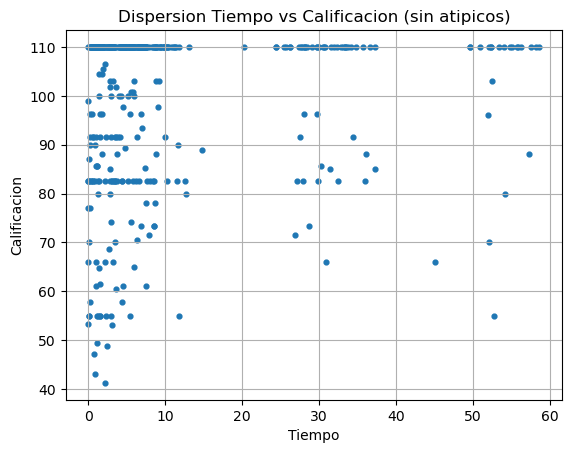

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("A1.6 Tiempo de Entrega.csv")

# Limpieza de atípicos (IQR) en Calificacion
Q1 = df["Calificacion"].quantile(0.25)
Q3 = df["Calificacion"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["Calificacion"] >= Q1 - 1.5*IQR) & (df["Calificacion"] <= Q3 + 1.5*IQR)]

# Limpieza de atípicos (IQR) en Tiempo
Q1_t = df["Tiempo"].quantile(0.25)
Q3_t = df["Tiempo"].quantile(0.75)
IQR_t = Q3_t - Q1_t
df = df[(df["Tiempo"] >= Q1_t - 1.5*IQR_t) & (df["Tiempo"] <= Q3_t + 1.5*IQR_t)]

print("Tamaño despues de limpiar:", df.shape)

plt.scatter(df["Tiempo"], df["Calificacion"], s=12)
plt.xlabel("Tiempo")
plt.ylabel("Calificacion")
plt.title("Dispersion Tiempo vs Calificacion (sin atipicos)")
plt.grid(True)
plt.show()

## Inciso 2 — División entrenamiento/prueba y revisión de promedios
Se realizó una división **70% entrenamiento y 30% prueba**.  
Los promedios fueron:

- Entrenamiento: Tiempo ≈ 10.75, Calificacion ≈ 98.3  
- Prueba: Tiempo ≈ 11.19, Calificacion ≈ 97.3  

Esto muestra que los subconjuntos son bastante similares, lo cual asegura una buena representatividad para evaluar los modelos.

In [33]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

print("Promedios entrenamiento:\n", train_df.mean(numeric_only=True))
print("\nPromedios prueba:\n", test_df.mean(numeric_only=True))

Promedios entrenamiento:
 Tiempo          10.747360
Calificacion    98.298362
dtype: float64

Promedios prueba:
 Tiempo          11.193449
Calificacion    97.260242
dtype: float64


## Inciso 3 — Regresión Polinomial
Se entrenó un modelo de **regresión polinomial de grado 3**.  
El modelo logró capturar la curvatura de la relación entre *Tiempo* y *Calificacion*.  

Se observa que a medida que el tiempo de entrega aumenta (se entrega más tarde), las calificaciones tienden a disminuir, aunque con cierta dispersión en valores altos.


In [34]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

X_tr = train_df[["Tiempo"]].values
y_tr = train_df["Calificacion"].values

poly = PolynomialFeatures(degree=3)
X_tr_poly = poly.fit_transform(X_tr)
reg_poly = LinearRegression().fit(X_tr_poly, y_tr)

## Inciso 4 — Regresión Segmentada
Se calculó un punto de quiebre en la mediana del tiempo de entrega.  
A partir de este *knot*, se entrenaron dos regresiones cuadráticas:  

- Una para los tiempos menores o iguales al quiebre.  
- Otra para los tiempos mayores al quiebre.  

Esto permitió ajustar mejor los datos en cada segmento, aunque la mejora respecto al modelo polinomial no fue significativa.

In [35]:
import numpy as np

knot = np.median(X_tr)

izq = train_df[train_df["Tiempo"] <= knot]
der = train_df[train_df["Tiempo"] > knot]

reg_izq = LinearRegression().fit(
    PolynomialFeatures(2).fit_transform(izq[["Tiempo"]]),
    izq["Calificacion"]
)
reg_der = LinearRegression().fit(
    PolynomialFeatures(2).fit_transform(der[["Tiempo"]]),
    der["Calificacion"]
)

## Inciso 5 — Regresión KNN
Se probó KNN con diferentes valores de *k = {3, 5, 7, 9, 11}*.  
El mejor resultado se obtuvo con **k = 3**, logrando el menor error en entrenamiento.  

Este modelo ajusta bien los puntos cercanos, pero genera curvas más irregulares y menos interpretables en comparación con los modelos polinomiales.

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

best_k, best_rmse = None, float("inf")
for k in [3,5,7,9,11]:
    knn = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=k))])
    knn.fit(X_tr, y_tr)
    pred = knn.predict(X_tr)
    rmse = float(np.sqrt(np.mean((y_tr - pred)**2)))
    if rmse < best_rmse:
        best_rmse, best_k = rmse, k

knn_best = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=best_k))]).fit(X_tr, y_tr)

## Inciso 6 — Evaluación de los modelos
Se calcularon los errores RMSE en el conjunto de prueba:

- **Polinomial (grado 3):** ≈ 17.73  
- **Segmentada (2 cuadráticas):** ≈ 17.82  
- **KNN (k=3):** ≈ 19.34  

El modelo **Polinomial** resultó ser el más preciso en este caso, aunque la diferencia con el modelo segmentado fue mínima.

In [37]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures  # ya importado antes; aquí solo por referencia en esta celda

X_te = test_df[["Tiempo"]].values
y_te = test_df["Calificacion"].values

# Polinomial
pred_poly = reg_poly.predict(poly.transform(X_te))

# Segmentada (conservar el orden original)
mask_izq = (X_te.ravel() <= knot)
mask_der = ~mask_izq
pred_seg = np.empty_like(y_te, dtype=float)
pred_seg[mask_izq] = reg_izq.predict(PolynomialFeatures(2).fit_transform(X_te[mask_izq]))
pred_seg[mask_der] = reg_der.predict(PolynomialFeatures(2).fit_transform(X_te[mask_der]))

# KNN
pred_knn = knn_best.predict(X_te)

print("RMSE Polinomial:", float(np.sqrt(np.mean((y_te - pred_poly)**2))))
print("RMSE Segmentada:", float(np.sqrt(np.mean((y_te - pred_seg)**2))))
print("RMSE KNN:", float(np.sqrt(np.mean((y_te - pred_knn)**2))))

RMSE Polinomial: 17.72855754586036
RMSE Segmentada: 17.822028944258268
RMSE KNN: 19.34239285205418


## Inciso 7 — Gráfica comparativa de modelos
En la gráfica se muestran los puntos reales de prueba junto con las curvas de los tres modelos:

- **Polinomial (grado 3):** línea naranja suave.  
- **Segmentada:** línea azul dividida en dos cuadráticas.  
- **KNN (k=3):** línea verde con forma irregular.  

La comparación visual confirma que el modelo polinomial logra un ajuste más estable y coherente en relación a los datos reales.

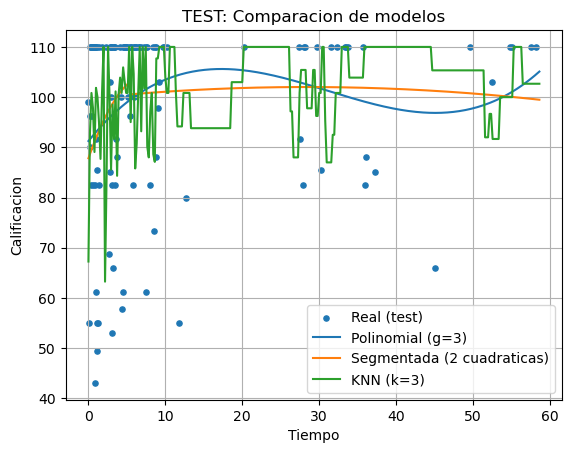

In [40]:
# Rango de x para dibujar curvas suaves
x_range = np.linspace(df["Tiempo"].min(), df["Tiempo"].max(), 300).reshape(-1,1)

# Polinomial (usa reg_poly y poly del inciso 3)
y_poly_curve = reg_poly.predict(poly.transform(x_range))

# Segmentada (usa reg_izq, reg_der y knot del inciso 4)
mask_left = (x_range.ravel() <= knot)
mask_right = ~mask_left
y_seg_curve = np.empty_like(x_range.ravel(), dtype=float)
y_seg_curve[mask_left]  = reg_izq.predict(PolynomialFeatures(2).fit_transform(x_range[mask_left]))
y_seg_curve[mask_right] = reg_der.predict(PolynomialFeatures(2).fit_transform(x_range[mask_right]))

# KNN (usa knn_best del inciso 5)
y_knn_curve = knn_best.predict(x_range)

# Puntos reales (set de prueba) + curvas
plt.scatter(X_te, y_te, label="Real (test)", s=14)
plt.plot(x_range, y_poly_curve, label="Polinomial (g=3)")
plt.plot(x_range, y_seg_curve, label="Segmentada (2 cuadraticas)")
plt.plot(x_range, y_knn_curve, label=f"KNN (k={best_k})")
plt.xlabel("Tiempo")
plt.ylabel("Calificacion")
plt.title("TEST: Comparacion de modelos")
plt.legend()
plt.grid(True)
plt.show()

## Conclusión General
La actividad permitió analizar la relación entre el tiempo de entrega y la calificación aplicando distintos modelos de regresión no lineal. Después de limpiar los datos y dividirlos en entrenamiento y prueba, se comprobó que los subconjuntos eran consistentes. Entre los modelos evaluados (polinomial, segmentado y KNN), el polinomial de grado 3 mostró el mejor desempeño con el menor RMSE y una curva más estable e interpretativa, mientras que el segmentado ofreció un resultado muy cercano pero sin superar al polinomial, y el KNN presentó mayor variabilidad y menor interpretabilidad. En conclusión, aunque el modelo polinomial es el que más se ajusta a los datos, esto no comprueba de manera definitiva la hipótesis sobre la relación entre entregar más tarde y obtener menor calificación, sino que únicamente sugiere una posible tendencia que debería validarse con más evidencia.